In [1]:
from random import shuffle
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch import nn

mms = MinMaxScaler()
pca = PCA(n_components=2)

mnist = fetch_openml('mnist_784')
X_orig, y_orig = mnist["data"], mnist["target"]

X_orig = mms.fit_transform(np.array(X_orig).astype(np.float32))
y_orig = np.array(y_orig).astype(np.uint8)
target_digit1 = 3
target_digit2 = 8

target_digit1_xdata = X_orig[y_orig == target_digit1]
target_digit2_xdata = X_orig[y_orig == target_digit2]
target_digit1_ydata = y_orig[y_orig == target_digit1]
target_digit2_ydata = y_orig[y_orig == target_digit2]
X = np.concatenate((target_digit1_xdata, target_digit2_xdata), axis=0)
y = np.concatenate((target_digit1_ydata, target_digit2_ydata), axis=0)

y = np.where(y == target_digit1, -1, 1)

# reduce the dimensions of X
# X = pca.fit_transform(X)
# scale to 0/1
X = mms.fit_transform(X)

# add on the bias
X = np.concatenate([np.ones_like(X[:, :1]), X],axis=-1)

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# pca.fit(X_train)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(8379, 785) (2793, 785) (2794, 785)
(8379,) (2793,) (2794,)


In [3]:
X_train = X_train
y_train = y_train

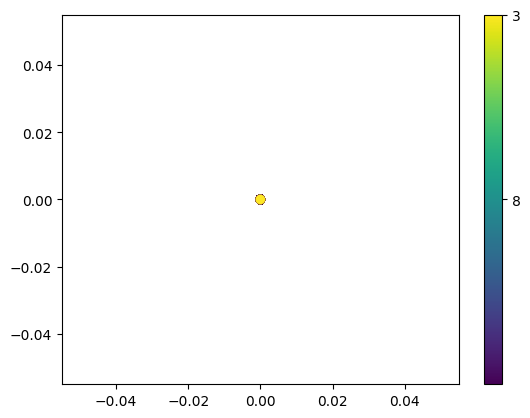

In [4]:
# pca2 = PCA(n_components=2)
# plotx = pca.fit_transform(X_train)

formatter = plt.FuncFormatter(lambda i, *args: np.where(y_train[i] == 1, target_digit2, target_digit1))
plt.scatter(X_train[:, 1], X_train[:, 2], c=y_train)
plt.colorbar(ticks=[0, 1], format=formatter)
# plt.xlabel(iris.feature_names[x_index])
# plt.ylabel(iris.feature_names[y_index])
plt.show()

In [5]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
device = 'cpu'
X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.Tensor(y_test).to(device)
X_val = torch.Tensor(X_val).to(device)
y_val = torch.Tensor(y_val).to(device)
train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=1024)
test_dl = TensorDataset(X_test, y_test)
val_dl = TensorDataset(X_val, y_val)


In [6]:
class LinearSVM(nn.Module):
    def __init__(self, dim, C=1.0):
        super().__init__()
        self.dim = dim
        self.w = nn.Parameter(torch.zeros(self.dim))
        self.C = C

    def forward(self, x):
        return x @ self.w

    def svm_loss(self, X, y, C=None, regularize_bias=False):
        C = C or self.C
        y = y.to(self.w.dtype)                          # y in {-1,+1}, float
        s = self(X)
        hinge = torch.clamp(1.0 - y * s, min=0.0)
        data_term = hinge.pow(2).mean()

        if regularize_bias:
            reg = 0.5 * (self.w @ self.w)
        else:
            reg = 0.5 * (self.w[1:] @ self.w[1:])

        return reg + C * data_term

C = 1.0

lr = 1e-2
num_epochs = 10


dim = X_train.size(1)
model = LinearSVM(dim, C=1.0).to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-2)

num_epochs = 500
sb = tqdm(range(num_epochs))
tl = []
for epoch in sb:
    for Xb, yb in train_dl:
        loss = model.svm_loss(Xb, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            loss = model.svm_loss(X_val, y_val)
            tl.append(loss.item())
            sb.set_postfix(loss=tl[-1])


100%|██████████| 500/500 [00:18<00:00, 27.04it/s, loss=0.324]


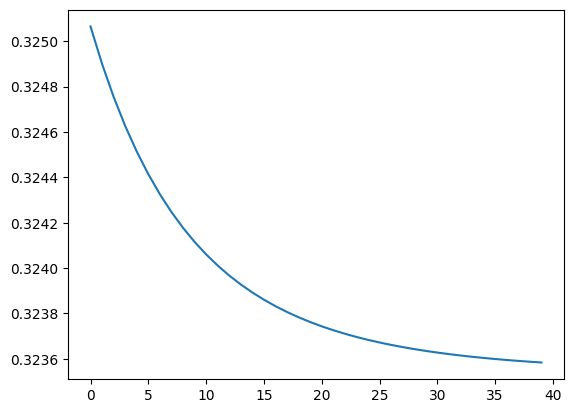

In [7]:
from matplotlib import pyplot as plt
tlnp = np.array(tl)
tlnp = tlnp[10:]
plt.plot(tlnp)
plt.show()

In [8]:
y_pred = (X_test @ model.w > 0) * 1.0


In [9]:
y_test_np = (y_test.detach().numpy() + 1.0)/2
y_pred_np = y_pred.detach().numpy()

In [10]:
from sklearn import metrics
print(metrics.accuracy_score(y_test_np, y_pred_np))
print(metrics.precision_score(y_test_np, y_pred_np))
print(metrics.recall_score(y_test_np, y_pred_np))
metrics.confusion_matrix(y_test_np, y_pred_np)

0.9566774078052274
0.95
0.9618488628026413


array([[1361,   69],
       [  52, 1311]])

# Now to break it

In [116]:
for param in model.parameters():
    param.requires_grad = False


In [130]:
num_epochs = 1000
l2_reg = 0.5

perturbation = torch.rand(X_train.size(1)) * 0.001
perturbation.requires_grad = True

opt = torch.optim.SGD([perturbation], lr=1e-1)

Xb = X_train[:1, :]
yb = y_train[:1]
yb_pred_new = model(Xb).sign().detach().numpy()
yb_pred_new

sb = tqdm(range(num_epochs))
tl = []
for epoch in sb:
    new_Xb = torch.clamp(Xb + perturbation, 0.0, 1.0)
    new_yb = yb * -1
    loss = model.svm_loss(new_Xb, new_yb)

    l2_loss = perturbation.norm()
    total_loss = loss + l2_reg * l2_loss
    opt.zero_grad()
    total_loss.backward()
    opt.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            pred = model(new_Xb).sign().detach().numpy()
            # print(pred != yb_pred_new, np.sum(pred != yb_pred_new))
            # break
            if np.sum(pred != yb_pred_new) >= len(pred):
                print("Finished!")
                break
            loss = model.svm_loss(Xb + perturbation, yb)
            tl.append(loss.item())
            sb.set_postfix(loss=tl[-1])


  3%|▎         | 30/1000 [00:00<00:00, 2936.23it/s, loss=0.889]

Finished!


In [131]:
# y_pred = ((X_test + perturbation) @ model.w > 0) * 1.0
# y_test_np = (y_test.detach().numpy() + 1.0) / 2
# y_pred_np = y_pred.detach().numpy()
# from sklearn import metrics
#
# print(metrics.accuracy_score(y_test_np, y_pred_np))
# print(metrics.precision_score(y_test_np, y_pred_np))
# print(metrics.recall_score(y_test_np, y_pred_np))
# metrics.confusion_matrix(y_test_np, y_pred_np)

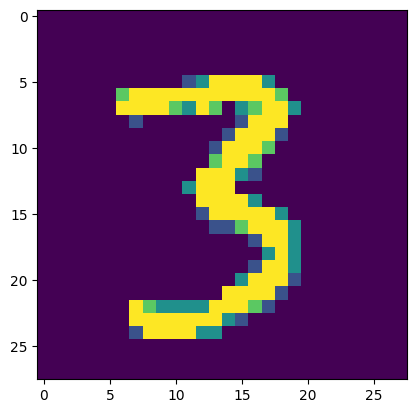

In [132]:
plt.imshow(Xb[:1, 1:].reshape((28,28)))

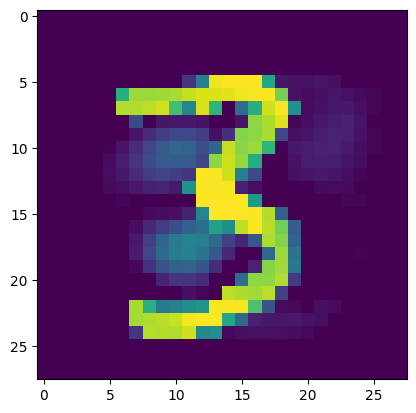

In [133]:
plt.imshow((Xb[:1] + perturbation.detach())[:, 1:].reshape((28,28)))

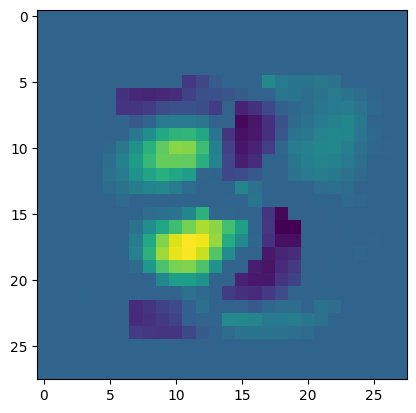

In [134]:
plt.imshow((perturbation.detach())[1:].reshape((28,28)))

Step 0, Loss: 4.6197
Step 2, Loss: 4.5181
Step 4, Loss: 4.4188
Step 6, Loss: 4.3218
Step 8, Loss: 4.2269
Step 10, Loss: 4.1342
Step 12, Loss: 4.0435
Step 14, Loss: 3.9549
Step 16, Loss: 3.8683
Step 18, Loss: 3.7837
Step 20, Loss: 3.7009
Step 22, Loss: 3.6200
Step 24, Loss: 3.5409
Step 26, Loss: 3.4636
Step 28, Loss: 3.3881
Step 30, Loss: 3.3142
Step 32, Loss: 3.2420
Step 34, Loss: 3.1714
Step 36, Loss: 3.1025
Step 38, Loss: 3.0350
Step 40, Loss: 2.9691
Step 42, Loss: 2.9047
Step 44, Loss: 2.8417
Step 46, Loss: 2.7801
Step 48, Loss: 2.7200
Step 50, Loss: 2.6611
Step 52, Loss: 2.6036
Step 54, Loss: 2.5474
Step 56, Loss: 2.4925
Step 58, Loss: 2.4388
Step 60, Loss: 2.3863
Step 62, Loss: 2.3349
Step 64, Loss: 2.2848
Step 66, Loss: 2.2357
Step 68, Loss: 2.1878
Step 70, Loss: 2.1410
Step 72, Loss: 2.0952
Step 74, Loss: 2.0504
Step 76, Loss: 2.0066
Step 78, Loss: 1.9638
Step 80, Loss: 1.9220
Step 82, Loss: 1.8812
Step 84, Loss: 1.8412
Step 86, Loss: 1.8021
Step 88, Loss: 1.7640
Step 90, Loss: 